In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from midiutil.MidiFile import MIDIFile
import pygame

# Image Preprocessing

In [2]:
img = cv2.imread('Images/TTLS.png', 0)

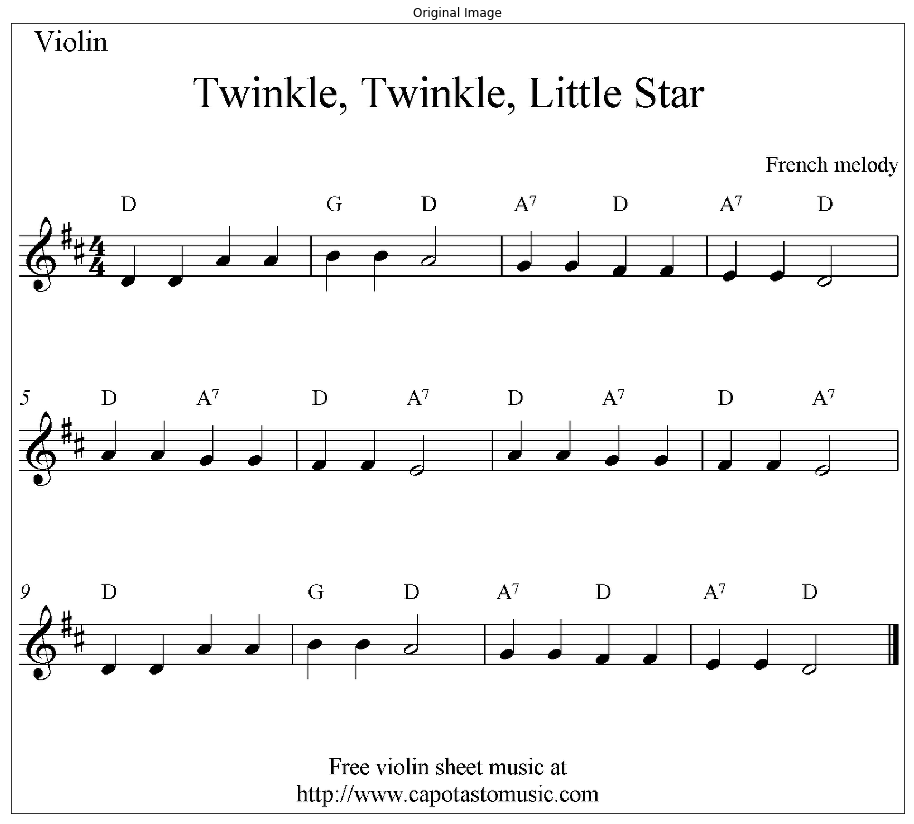

In [3]:
plt.figure(figsize=(16,16))
plt.imshow(img, cmap = 'gray')
plt.xticks([]), plt.yticks([])
plt.title('Original Image')
plt.show()

In [4]:
blur = cv2.GaussianBlur(img,(3,3),0)
# blur = cv2.medianBlur(img, 3)
thresh, img_bw = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

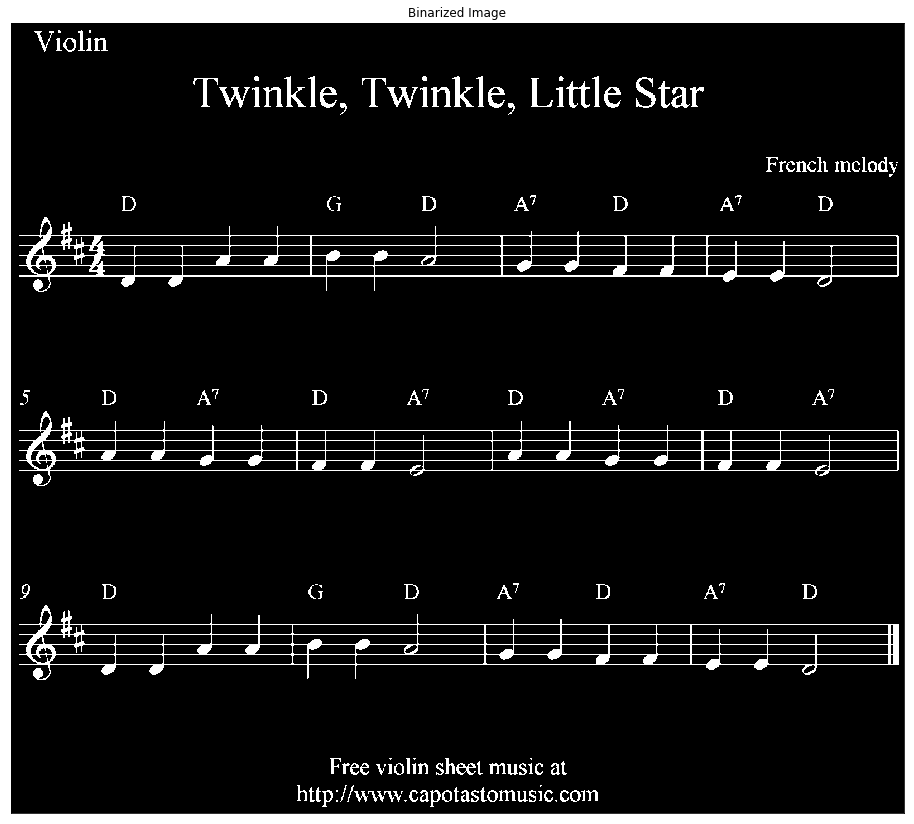

In [5]:
plt.figure(figsize=(16,16))
plt.imshow(img_bw, cmap = 'gray')
plt.xticks([]), plt.yticks([])
plt.title('Binarized Image')
plt.show()

# Segmentation

In [6]:
def horizontal_projection(img):
    h,w = img.shape
    row_sum = []
    for i in range(h):
        row_sum.append(sum(img[i, 0:w]))
    return row_sum

In [7]:
def vertical_projection(img):
    h,w = img.shape
    col_sum = []
    for i in range(w):
        col_sum.append(sum(img[0:h, i]))
    return col_sum

In [8]:
h,w = img.shape

row_sum = horizontal_projection(img_bw)
col_sum = vertical_projection(img_bw)

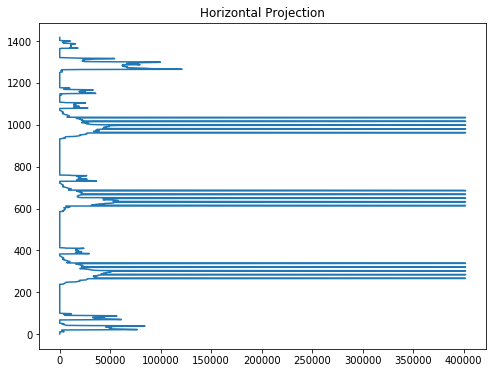

In [9]:
plt.figure(figsize=(8,6))
plt.plot(row_sum, range(h,0,-1))
plt.title('Horizontal Projection')
plt.show()

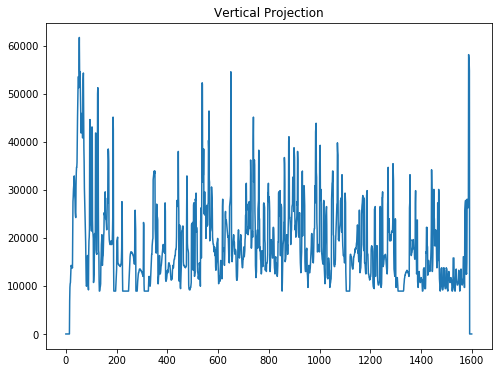

In [10]:
plt.figure(figsize=(8,6))
plt.plot(range(w), col_sum)
plt.title('Vertical Projection')
plt.show()

In [11]:
hp_max = max(row_sum)
for i in range(len(row_sum)):
    if row_sum[i] < 0.9*hp_max:
        row_sum[i] = 0

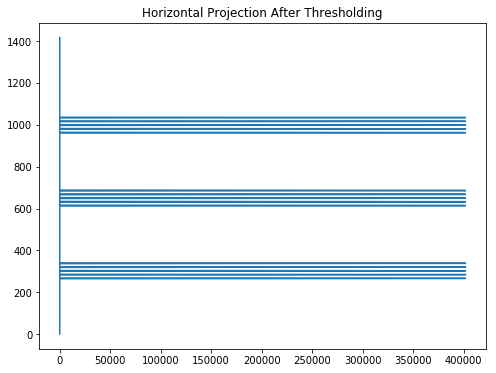

In [12]:
plt.figure(figsize=(8,6))
plt.plot(row_sum, range(h,0,-1))
plt.title('Horizontal Projection After Thresholding')
plt.show()

In [13]:
staff_lines = []
for i in range(len(row_sum)):
    if row_sum[i]>0:
        staff_lines.append(i)
len(staff_lines)

35

In [14]:
grand_stave_start = []
grand_stave_end = []

grand_stave_start.append(staff_lines[0])
for i in range(len(staff_lines)-1):
    if staff_lines[i+1]-staff_lines[i]>20:
        grand_stave_end.append(staff_lines[i])
        grand_stave_start.append(staff_lines[i+1])
grand_stave_end.append(staff_lines[i+1])
        
print(grand_stave_start)
print(grand_stave_end)

[382, 730, 1078]
[455, 804, 1151]


In [15]:
grand_staves = []
for i in range(len(grand_stave_start)):
    grand_staves.append(img_bw[grand_stave_start[i]-40:grand_stave_end[i]+40])
len(grand_staves)

3

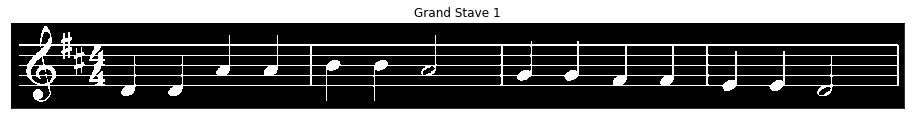

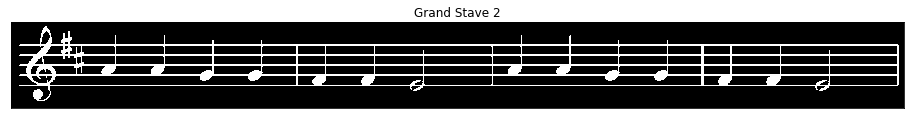

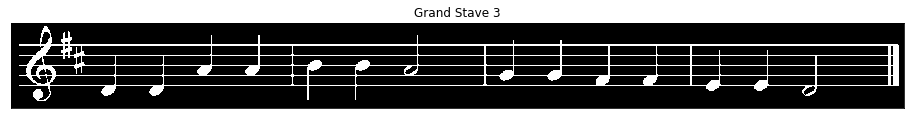

In [16]:
count=0
for i in grand_staves:
    count+=1
    plt.figure(figsize=(16,16))
    plt.imshow(i, cmap = 'gray')
    plt.xticks([]), plt.yticks([])
    plt.title('Grand Stave {}'.format(count))
    plt.show()

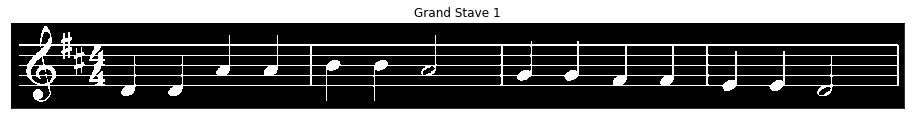

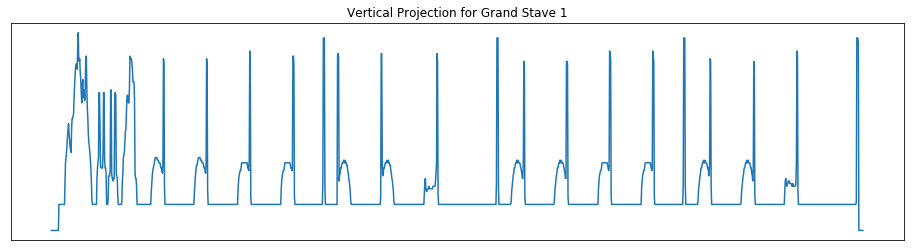

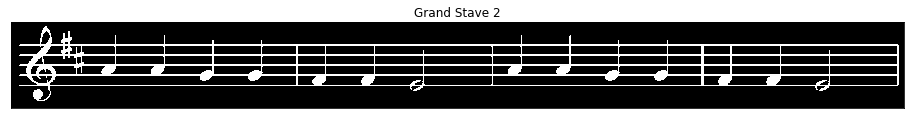

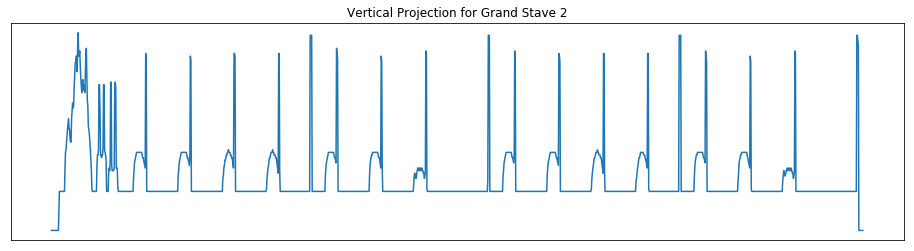

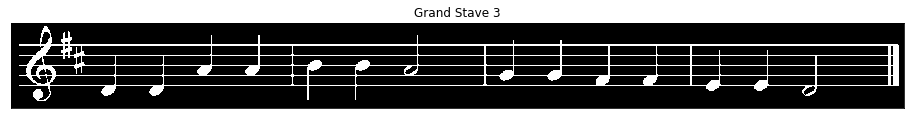

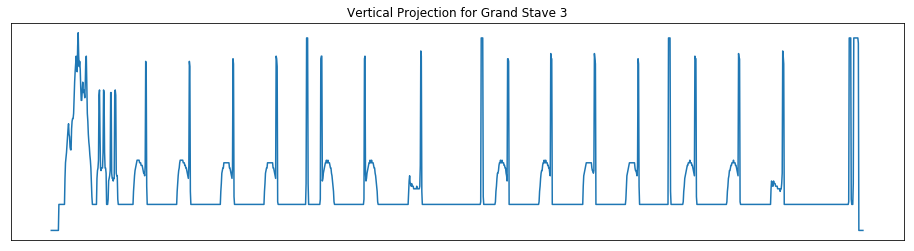

In [17]:
bar_dict = {}
bar_height_list = []
count=0

for i in grand_staves:
    count+=1
    plt.figure(figsize=(16,16))
    plt.imshow(i, cmap = 'gray')
    plt.xticks([]), plt.yticks([])
    plt.title('Grand Stave {}'.format(count))
    
    col_sum = vertical_projection(i)
    vp_max = max(col_sum)
    bar_height_list.append(vp_max)
    bar_lines = []
    
    for j in range(len(col_sum)):
        if col_sum[j] < 0.9*vp_max:
            col_sum[j] = 0
        else:
            bar_lines.append(j)

    bar_dict[count-1] = bar_lines
    
    col_sum = vertical_projection(i)
    vp_max = max(col_sum)
    plt.figure(figsize=(16,4))
    plt.plot(range(w), col_sum)
    plt.xticks([]), plt.yticks([])
    plt.title('Vertical Projection for Grand Stave {}'.format(count))
    plt.show()
    
bar_height_avg = int(np.mean(bar_height_list)/255)

In [18]:
staff_lines_avg = []
temp = []

for i in range(len(staff_lines)-1):
    if staff_lines[i+1]-staff_lines[i]<2:
        temp.append(staff_lines[i])
        temp.append(staff_lines[i+1])
    else:
        staff_lines_avg.append(int(round(np.mean(list(set(temp))))))
        temp = []

staff_lines_avg.append(int(round(np.mean(list(set(temp))))))
len(staff_lines_avg)

15

In [19]:
def crop_notes(img, img_copy, counter=0):
    img_height, img_width = img.shape
    note_point_list = []

    image_transpose = img.transpose()
    labels = measure.label(image_transpose, neighbors=8, background=0)

    for label in np.unique(labels):
        if label == 0:
            continue

        labelMask = np.zeros(image_transpose.shape, dtype="uint8")
        labelMask[labels == label] = 255

        note = labelMask.transpose()
        numPixels = cv2.countNonZero(note)

        if numPixels > 25:
            row_sum = horizontal_projection(note)
            hp_max = max(row_sum)
            for i in range(len(row_sum)):
                if row_sum[i] < 0.5*hp_max:
                    row_sum[i] = 0

            note_point = [i for i, x in enumerate(row_sum) if x][-1]
            note_point_list.append(note_point)

            x,y,w,h = cv2.boundingRect(note)
            filename = 'Output/'+str(counter)+'.jpg'
            crop_img = img_copy[0:img_height, x:x+w]
            cv2.imwrite(filename, crop_img)
            counter += 1
            cv2.rectangle(img,(x-5,y-5),(x+w+5,y+h+5),(255,255,255),2)

    plt.figure(figsize=(16,16))
    plt.imshow(img, cmap = 'gray')
    plt.xticks([]), plt.yticks([])
    plt.title('Detected Notes')
    plt.show()
    
    return counter, note_point_list

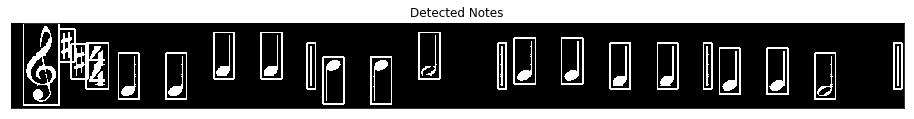

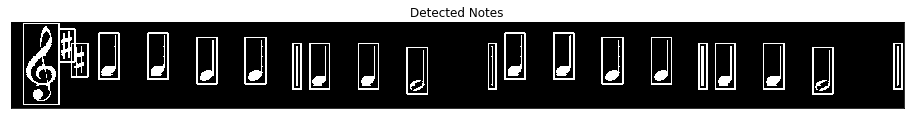

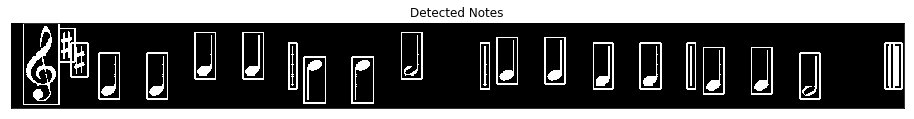

In [20]:
counter = 0
key_count = 0
last_staff_line_dict = {}
note_point_dict = {}

for k in grand_staves:
    img_copy = k.copy()
    
    row_sum = horizontal_projection(k)
    hp_max = max(row_sum)

    for i in range(len(row_sum)):
        if row_sum[i] < 0.9*hp_max:
            row_sum[i] = 0

    staff_lines = []
    for i in range(len(row_sum)):
        if row_sum[i]>0:
            staff_lines.append(i)

    for i in staff_lines:
        for j in range(w): 
            if sum(k[i-5:i+5, j])<1500:
                k[i,j]=0
    
    staff_lines_avg = []
    temp = []

    for i in range(len(staff_lines)-1):
        if staff_lines[i+1]-staff_lines[i]<2:
            temp.append(staff_lines[i])
            temp.append(staff_lines[i+1])
        else:
            staff_lines_avg.append(int(round(np.mean(list(set(temp))))))
            temp = []

    staff_lines_avg.append(int(round(np.mean(list(set(temp))))))
    last_staff_line_dict[key_count] = staff_lines_avg[-1]

    counter, note_point_list = crop_notes(k, img_copy, counter)
    note_point_dict[key_count] = note_point_list
    key_count+=1

# Note Recognition


Image 0
Matching Template = treble_clef


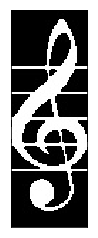


Image 1
Image size is smaller than Template size

Image 2
Matching Template = sharp


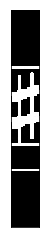


Image 3
Matching Template = time_4


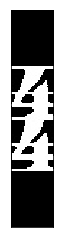


Image 4
Matching Template = quarter_note


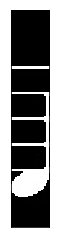


Image 5
Matching Template = quarter_note


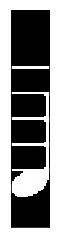


Image 6
Matching Template = quarter_note


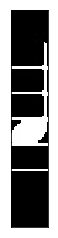


Image 7
Matching Template = quarter_note


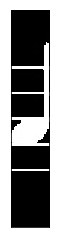


Image 8
Image size is smaller than Template size

Image 9
Matching Template = quarter_note


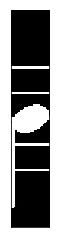


Image 10
Matching Template = quarter_note


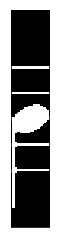


Image 11
Matching Template = half_note


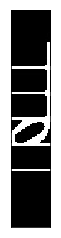


Image 12
Image size is smaller than Template size

Image 13
Matching Template = quarter_note


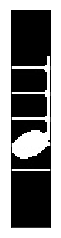


Image 14
Matching Template = quarter_note


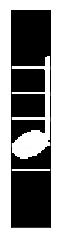


Image 15
Matching Template = quarter_note


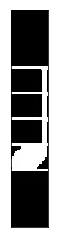


Image 16
Matching Template = quarter_note


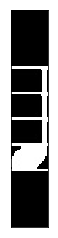


Image 17
Image size is smaller than Template size

Image 18
Matching Template = quarter_note


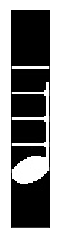


Image 19
Matching Template = quarter_note


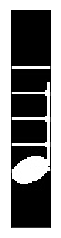


Image 20
Matching Template = half_note


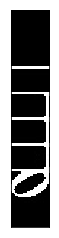


Image 21
Image size is smaller than Template size

Image 22
Matching Template = treble_clef


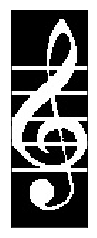


Image 23
Image size is smaller than Template size

Image 24
Image size is smaller than Template size

Image 25
Matching Template = quarter_note


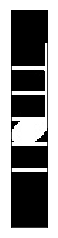


Image 26
Matching Template = quarter_note


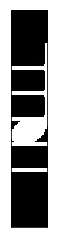


Image 27
Matching Template = quarter_note


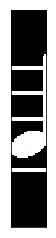


Image 28
Matching Template = quarter_note


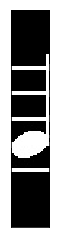


Image 29
Image size is smaller than Template size

Image 30
Matching Template = quarter_note


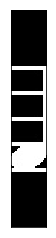


Image 31
Matching Template = quarter_note


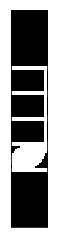


Image 32
Matching Template = quarter_note


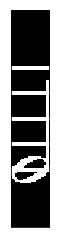


Image 33
Image size is smaller than Template size

Image 34
Matching Template = quarter_note


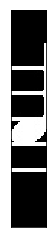


Image 35
Matching Template = quarter_note


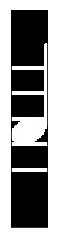


Image 36
Matching Template = quarter_note


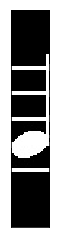


Image 37
Matching Template = quarter_note


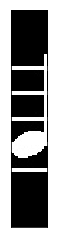


Image 38
Image size is smaller than Template size

Image 39
Matching Template = quarter_note


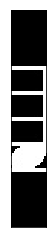


Image 40
Matching Template = quarter_note


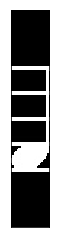


Image 41
Matching Template = quarter_note


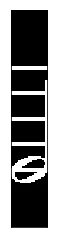


Image 42
Image size is smaller than Template size

Image 43
Matching Template = treble_clef


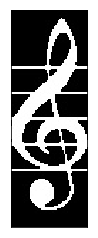


Image 44
Image size is smaller than Template size

Image 45
Matching Template = sharp


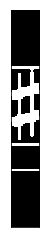


Image 46
Matching Template = quarter_note


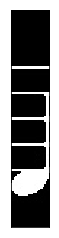


Image 47
Matching Template = quarter_note


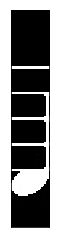


Image 48
Matching Template = quarter_note


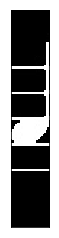


Image 49
Matching Template = quarter_note


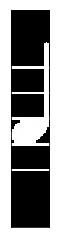


Image 50
Image size is smaller than Template size

Image 51
Matching Template = quarter_note


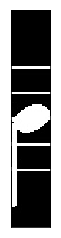


Image 52
Matching Template = quarter_note


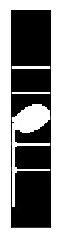


Image 53
Matching Template = half_note


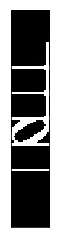


Image 54
Image size is smaller than Template size

Image 55
Matching Template = quarter_note


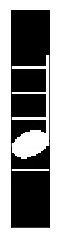


Image 56
Matching Template = quarter_note


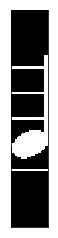


Image 57
Matching Template = quarter_note


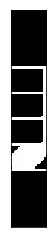


Image 58
Matching Template = quarter_note


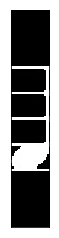


Image 59
Image size is smaller than Template size

Image 60
Matching Template = quarter_note


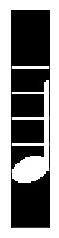


Image 61
Matching Template = quarter_note


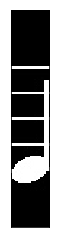


Image 62
Matching Template = half_note


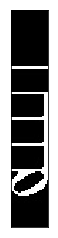


Image 63
Image size is smaller than Template size

Image 64
Image size is smaller than Template size


In [21]:
template_names = ['half_note', 'quarter_note', 'whole_note', 'treble_clef', 'bass_clef', 'time_4', 'sharp']
mapping_dict = {-18: 'D', -9: 'E', 0: 'F', 9: 'G', 18: 'A', 27: 'B', 36: 'C', 45: 'D', 54: 'E', 63: 'F', 72: 'G'}

best_match = None
recognized_notes = []
template_matching_result = []
time_gaps = []
img_counter=0

for key, value in note_point_dict.items():
    for i in range(len(value)):
        
        filename = 'Output/'+str(img_counter)+'.jpg'
        img = cv2.imread(filename, 0)
        max_score = -999

        for t in template_names:
            template_filename = 'Templates/'+str(t)+'.png'
            template = cv2.imread(template_filename, 0)
            template = cv2.resize(template, (20,20))

            h,w = template.shape
            img_h,img_w = img.shape
            if img_h<h or img_w<w:
                continue

            result = cv2.matchTemplate(img, template, cv2.TM_CCORR_NORMED)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

            if max_val>max_score:
                max_score = max_val
                best_match = t
            top_left = max_loc
            bottom_right = (top_left[0] + h, top_left[1] + w)
            
        min_distance = 9999
        if best_match != None and 'note' in best_match:
            distance = last_staff_line_dict[key] - note_point_dict[key][i]
            for k,v in mapping_dict.items():
                difference = abs(distance-k)
                if difference < min_distance:
                    nearest_note = mapping_dict[k]
                    min_distance = difference
            recognized_notes.append(nearest_note)
        
            if 'quarter' in best_match:
                time_gaps.append(1)
            elif 'half' in best_match:
                time_gaps.append(2)
            else:
                time_gaps.append(4)

        print("\nImage {}".format(img_counter))
        if max_score != -999:
            # print("Max Score = ", max_score)
            print("Matching Template = {}".format(best_match))
            template_matching_result.append(best_match)
            best_match = None
            plt.imshow(img, cmap = 'gray')
            plt.xticks([]), plt.yticks([])
            plt.show()
        else:
            print("Image size is smaller than Template size")
        
        img_counter+=1

In [22]:
sharp_sequence = 'F-C-G-D-A-E-B'
sharp_counter = template_matching_result.count('sharp')
total_sharp_count = int(round(sharp_counter/len(grand_staves)))

for i in range(total_sharp_count):
    replacement = sharp_sequence.split('-')[i]
    
    recognized_notes = [note.replace(replacement, replacement+'#') for note in recognized_notes]

# Generate Melody

In [23]:
midi_note_codes = []
midi_mapping_dict = {'C': 60, 'C#': 61, 'D': 62, 'D#': 63, 'E': 64, 'F': 65, 'F#': 66, 'G': 67, 'G#': 68, 'A': 69, 'A#': 70, 'B': 71}

for note in recognized_notes:
    midi_note_codes.append(midi_mapping_dict[note])

In [24]:
track    = 0
channel  = 0
time     = 0
duration = 1
tempo    = 100
volume   = 127

MyMIDI = MIDIFile(1)
MyMIDI.addTempo(track, time, tempo)

for counter in range(len(midi_note_codes)):
    MyMIDI.addNote(track, channel, midi_note_codes[counter], time, time_gaps[counter], volume)
    time = time + time_gaps[counter]

with open("Audio/TTLS.midi", "wb") as output_file:
    MyMIDI.writeFile(output_file)

In [25]:
sample_rate = 44100
channels = 2
buffer = 1024
bitsize = -16
pygame.mixer.init(sample_rate, bitsize, channels, buffer)
pygame.mixer.music.set_volume(1.0)

def play_music(music_file):

    try:
        pygame.mixer.music.load(music_file)

    except pygame.error:
        print ("Error playing %s! (%s)" % (music_file, pygame.get_error()))
        return

    pygame.mixer.music.play()

In [26]:
play_music('Audio/ttls.midi')